# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

# Summary

**I first studied the hedged profits for selling a European call option in three models with non-constant sigma and observed that**
1. The variance of volatility will lead to extra variance in the hedged profit.
2. When I fix the option premium based on the Black-Scholes price using a high constant volatility, the models with non-constant (stochastic) volatility consistently produce a lower mean hedged profit.
This indicates that if volatility is actually stochastic but we incorrectly model it as constant, the resulting Black-Scholes price tends to underestimate the true fair value of the option. 

**I then explored vega hedging as a way to reduce the portfolio’s sensitivity to volatility fluctuations.**
The approach I used was to buy $\frac{\text{call option vega}}{\text{put option vega}}$ put option for each sold call option, with both options having similar strike prices and expiration dates, and then delta hedge the combined position. I found that this strategy reduces the variance in hedged profits, indicating that vega hedging helps stabilize returns in the presence of stochastic volatility.

In [846]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
sns.set_style('darkgrid')

In [815]:
#Import functions associated with Black-Scholes Equations

%run functions_black_scholes.py


import types

# List all functions in functions_black_scholes.py
function_list = [name for name, obj in globals().items() if isinstance(obj, types.FunctionType)]
print(function_list[1:])

['open', '__import__', '_attempt_import', '_check_imported', '_jupyterlab_variableinspector_getsizeof', '_jupyterlab_variableinspector_getshapeof', '_jupyterlab_variableinspector_getcontentof', '_jupyterlab_variableinspector_is_matrix', '_jupyterlab_variableinspector_is_widget', '_jupyterlab_variableinspector_dict_list', '_jupyterlab_variableinspector_getmatrixcontent', '_jupyterlab_variableinspector_displaywidget', '_jupyterlab_variableinspector_default', '_jupyterlab_variableinspector_deletevariable', 'import_pandas_safely', 'is_data_frame', 'dataframe_columns', 'dtypes_str', 'dataframe_hash', 'get_dataframes', 'stock_path_custom_sigma', 'stock_path_Henston', 'stock_path_GARCH', 'bs_call_delta', 'bs_call_PnL', 'bs_call_PnL_custom_sigma', 'henston_call_PnL', 'garch_call_PnL', 'custom_sigma_call_delta_MC', 'custom_sigma_call_delta_array_MC', 'custom_sigma_call_PnL', 'call_options', '__nonzero__', 'bs_call', 'bs_put', 'bs_put_delta', 'bs_gamma', 'bs_vega', 'bs_call_theta', 'bs_put_theta

In [115]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths= S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return sigma, paths
    
    

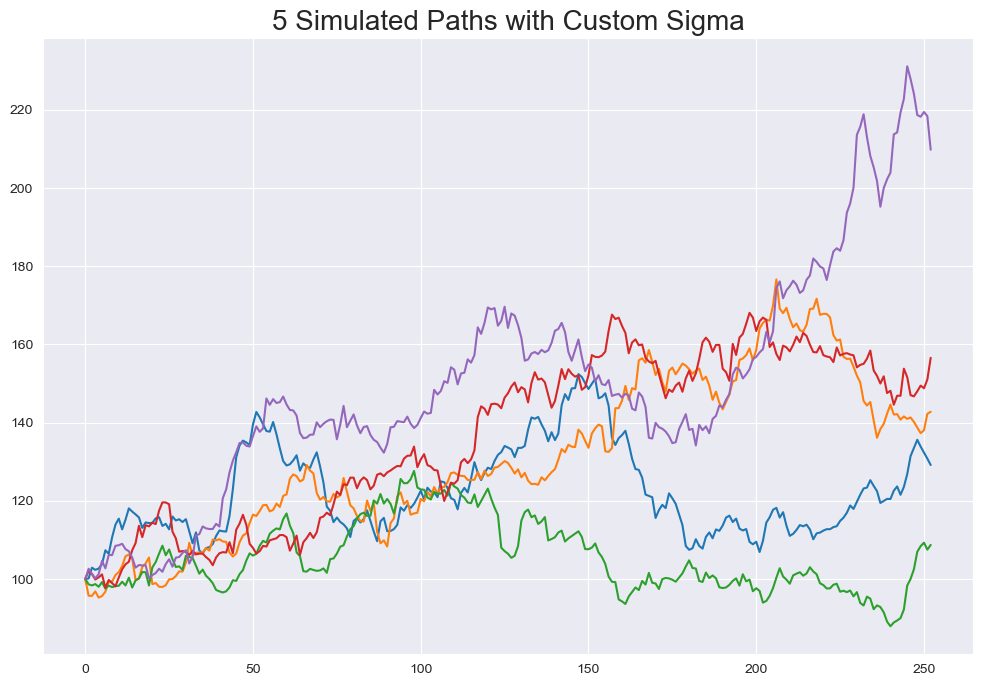

In [153]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


_,simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

### Let us first look at the stock path given by the Henston and the GARCH(1,1) model, and compare the distribution of profits of heging derived from these models and the Black-Scholes model

In [1183]:

### Henston model

def stock_path_Heston(S0, v0, t, r, mu, kappa, theta, xi, rho, n_paths,n_steps):
    """
    Simulation of stock path movements under the Heston stochastic volatility model.
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - t (float): Total time horizon (in years)
    - r (float): Risk-free interest rate
    - mu (float): Drift component (excess return above r)
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_steps (int): Number of time steps
    - n_paths (int): Number of simulated paths

    Returns:
    - paths (ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1)
    """
    dt = t / n_steps
    N1 = np.random.normal(0, 1, size=(n_paths, n_steps))
    N2 = np.random.normal(0, 1, size=(n_paths, n_steps))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    paths = np.zeros((n_paths, n_steps + 1))
    vols = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0
    vols[:, 0] = v0

    for i in range(n_steps):
        vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
                                xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
        paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * vols[:, i]) * dt +
                                               np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
    
    return vols, paths



### GARCH(1,1) for volatility

def stock_path_GARCH(S0, v0, t, r, mu, alpha, beta, theta, n_paths,n_steps):
    """
    Simulation of stock path movements under the GARCH(1,1) volatility model.
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - t (float): Total time horizon (in years)
    - r (float): Risk-free interest rate
    - mu (float): Drift component (excess return above r)
    - alpha (float): Reaction to last step stock price
    - beta (float): Persistence of last step variance
    - theta (float): Long-run variance
    - n_paths (int): Number of simulated paths
    - n_steps (int): Number of time steps
    


    Returns:
    - paths (ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1)
    """
    dt = t / n_steps
    noise = np.random.normal(0, 1, size=(n_paths, n_steps))


    paths = np.zeros((n_paths, n_steps + 1))
    len(paths)
    vols = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0
    vols[:, 0] = v0

    for i in range(n_steps):
        vols[:, i + 1] = theta+alpha*vols[:,i]*(noise[:, i]**2) + beta*vols[:,i]
        paths[:, i + 1] = paths[:,i]*np.exp((mu+r)*dt+ np.sqrt(vols[:,i]*dt)*noise[:, i])
    
    return vols,paths

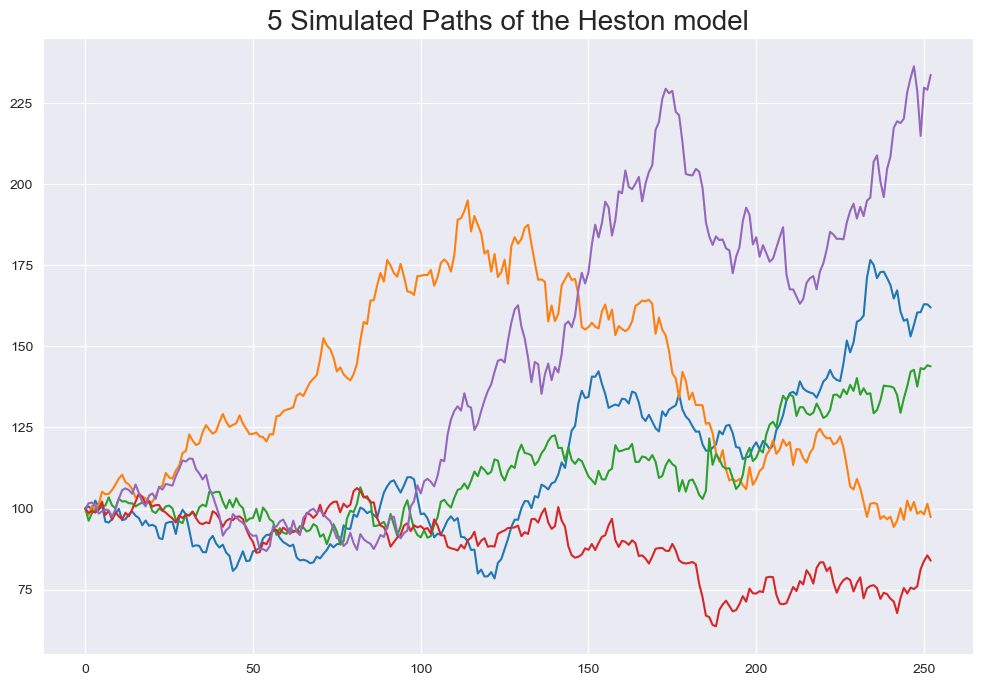

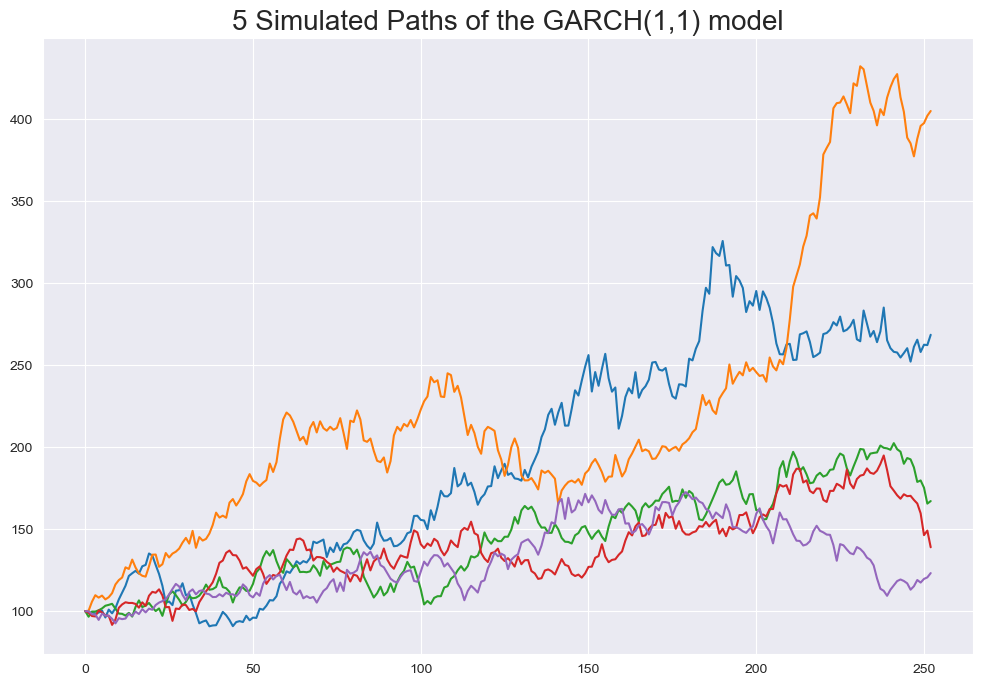

In [1319]:
#5 Simulated paths of daily steps over 1-year period and plot


S0 = 100
v0=0.28**2 # expectation value of the volatility given in stock_path_custom_sigma
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252
kappa = 4
theta = .45**2
xi = .5
rho = -0.05
alpha=0.1
beta=0.2


_,simulated_paths_Henston = stock_path_Heston(S0, v0, t, r, mu, kappa, theta, xi, rho, n_paths,n_steps)
_,simulated_paths_GARCH = stock_path_GARCH(S0, v0, t, r, mu, alpha, beta, theta, n_paths,n_steps)

plt.figure(figsize = (12,8))

for path in simulated_paths_Henston:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths of the Heston model', size = 20)

plt.figure(figsize = (12,8))
for path in simulated_paths_GARCH:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths of the GARCH(1,1) model', size = 20)


plt.show()

In [809]:
# Delta Hedging using these three volatility models

# first code the BS PnL for comparison
def bs_call_delta(S0, K, sigma, t, r):
    """
    Returns the Delta (sensitivity to spot price) of a European call option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Delta of Call Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1)

def bs_call_PnL(S0, K, sigma, t, r, n_paths, n_hedges, P, num_options, mu ):
    """
    Returns the PnL of a European call option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate
        mu (float): Drift component (excess return above r)
        n_paths (int): Number of Monte Carlo simulation paths
        n_hedges (int): Number of hedge rebalancing intervals
        P (float): Premium received per option sold
        num_options (int): Number of options sold

    Returns:
        np.array: Profit and loss of the dynamically hedged portfolio under each simulation at regular intervals
    """
   
    dt = t / n_hedges

    noise=np.random.normal(0,1,(n_paths,n_hedges))

    # Get the spot prices
    logreturns=np.cumsum((r+mu-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*noise,axis=1)
    paths=S0*np.exp(logreturns)

    #Simulate call payouts discounted to time 0
    path_end_points = paths[:,-1]
    call_payouts = np.maximum(path_end_points-K ,0)*np.exp(-r*t)


    #Simulate the stock profits using the BS delta function
    delta=bs_call_delta(S0,K,sigma,t,r)
    stock_profit_firsthedge=(paths[:,0]-np.exp(r*dt)*S0)*delta*np.exp(-r*dt)

    
    stock_profits = []
    stock_profits.append(stock_profit_firsthedge)

    for i in range(1,n_hedges):
        startpoints=paths[:,i-1]
        endpoints=paths[:,i]
        tte=t-i*dt
        deltas=bs_call_delta(startpoints,K,sigma,tte,r)
        
        stock_profit_otherhedges=(endpoints-np.exp(r*dt)*startpoints)*deltas*np.exp(-i*r*dt)
        stock_profits.append(stock_profit_otherhedges)

    
    total_stock_profit = np.sum(stock_profits, axis = 0)

    # Final P&L
    pnl = num_options * (P - call_payouts + total_stock_profit)

    return pnl


In [1462]:
K

110

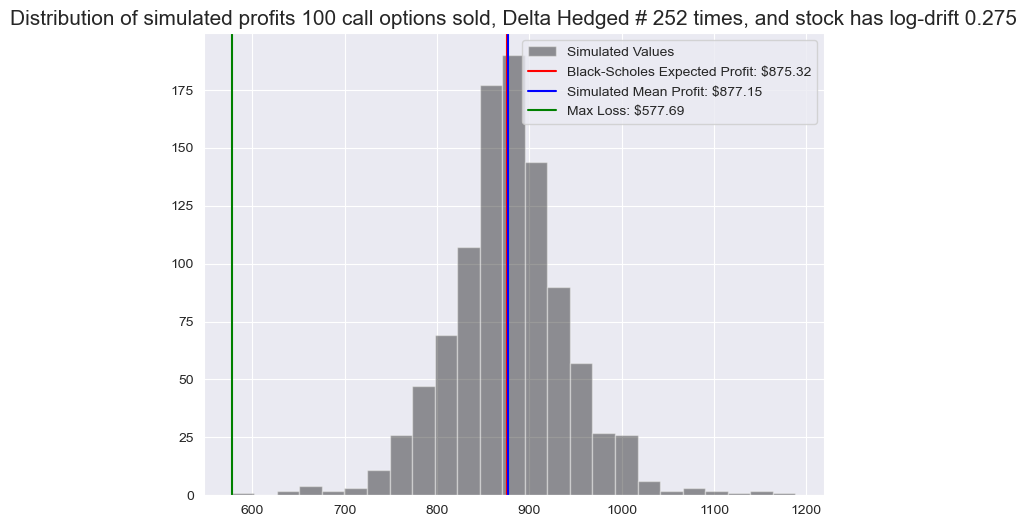

The standard deviation of profits of 252 hedgings under BS assumptions is 65.00621031160894 
p=4.2816743136071176e-13→ Statistically significant evidence that the data is NOT normally distributed.


In [867]:
S0 = 100
K=110
sigma=0.28
t = 1
r = 0.039
mu = 0.275
n_paths = 1000
n_hedges = 252
num_options=100
P= bs_call(S0,K,0.5,t,r)
bs_price = bs_call(S0,K,sigma,t,r)


profits_hedged=bs_call_PnL(S0, K, sigma, t, r, n_paths, n_hedges, P, num_options, mu )

plt.figure(figsize = (8,6))
    
plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
plt.axvline((P-bs_price)*num_options, label = f'Black-Scholes Expected Profit: ${(P-bs_price)*num_options:.2f}', color = 'red')
    
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')
    
plt.legend()

plt.title(f'Distribution of simulated profits {num_options} call options sold, Delta Hedged \
# {n_hedges} times, and stock has log-drift {mu}',size = 15)
    
plt.show()

print(f'The standard deviation of profits of 252 hedgings under BS assumptions is {np.std(profits_hedged)} ')

p = stats.normaltest(profits_hedged)[1]

if p < 0.05:
    print(f'p={p}→ Statistically significant evidence that the data is NOT normally distributed.')
else:
    print(f'p={p}→ No statistically significant evidence against normality.')

In [1144]:
# Delta hedge using the custom sigma defined at the beginning

# First look at the custom_sigma model, and start with calculating the delta function using MC

def custom_sigma_call_delta_MC(S0, K, t, r, mu, n_steps, n_delta_sims):
    """
    Returns the delta function of a European call option
    using the custom volatility for geometric Browian motion.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate
        mu (float): Drift component (excess return above r)
        n_steps (int): Number of random walk steps
        n_delta_sim (int): Number of Monte Carlo simulations
        P (float): Premium received per option sold
        num_options (int): Number of options sold

    Returns:
        float: delta function
    """

    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_delta_sims, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_delta_sims, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = ( r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths1 = (S0+0.01*S0)*np.exp(log_returns)[:,-1]
    paths2 = (S0-0.01*S0)*np.exp(log_returns)[:,-1]
    
    C1=np.maximum(paths1-K,0)*np.exp(-r*t)
    C2=np.maximum(paths2-K,0)*np.exp(-r*t)

    return np.mean((C1-C2)/(2*0.01*S0))

def custom_sigma_call_delta_array_MC(S, K, t, r, mu,n_steps, n_delta_sims):
    """
    Returns an array of delta functions of a European call option
    using the custom volatility for geometric Browian motion.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate
        mu (float): Drift component (excess return above r)
        n_steps (int): Number of random walk steps
        n_delta_sim (int): Number of Monte Carlo simulations
        P (float): Premium received per option sold
        num_options (int): Number of options sold

    Returns:
        np.array: an array of delta functions
    """
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_delta_sims, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_delta_sims, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = ( r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths1 = np.array([(S+0.01*S)*np.exp(log_returns)[:,-1]  for S in S])
    paths2 = np.array([(S-0.01*S)*np.exp(log_returns)[:,-1]  for S in S])
    
    C1=np.maximum(paths1-K,0)*np.exp(-r*t)
    C2=np.maximum(paths2-K,0)*np.exp(-r*t)

    return np.mean((C1.T-C2.T)/(2*0.01*S),axis=0)


In [1158]:
### test the delta function

S0 = 100
K=110
sigma=0.28
t = 1
r = 0.039
mu = 0.275
n_steps = 252
n_delta_sims = 1000
custom_sigma_call_delta_array_MC(np.array([100 for i in range(5)]), K, t, r, mu,n_steps, n_delta_sims)

### The delta from Monte Carlo simulation is noisy

array([0.45585851, 0.45585851, 0.45585851, 0.45585851, 0.45585851])

In [1164]:
# PnL for the custom sigma model
def custom_sigma_call_PnL(S0, t, r, mu, n_paths,n_hedges, K, P, num_options):
    """
    Returns the PnL of a European call option
    using the custom volatility for geometric Browian motion.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate
        mu (float): Drift component (excess return above r)
        n_hedges (int): Number of hedges
        n_paths (int): Number of Monte Carlo simulations
        P (float): Premium received per option sold
        num_options (int): Number of options sold

    Returns:
        np.array: PnL
    """
   
    dt = t / n_hedges


    # Get the spot prices using the function defined above
    sigma,paths=stock_path_custom_sigma(S0, t, r, mu, n_paths, n_hedges)

    #Simulate call payouts discounted to time 0
    path_end_points = paths[:,-1]
    call_payouts = np.maximum(path_end_points-K ,0)*np.exp(-r*t)


    #Simulate the stock profits using the BS delta function
    
    stock_profits = []

    for i in range(1,n_hedges+1):
        startpoints=paths[:,i-1]
        endpoints=paths[:,i]
        tte=t-(i-1)*dt
        n_steps=n_hedges-(i-1)
        #deltas=custom_sigma_call_delta_array_MC(startpoints, K, tte, r, mu,n_steps, n_delta_sims=1000)
        deltas=bs_call_delta(startpoints,K,sigma[:,i-1],tte,r)
        
        stock_profit=(endpoints-np.exp(r*dt)*startpoints)*deltas*np.exp(-i*r*dt)
        stock_profits.append(stock_profit)

    
    total_stock_profit = np.sum(stock_profits, axis = 0)

    # Final P&L
    pnl = num_options * (P - call_payouts + total_stock_profit)

    return pnl

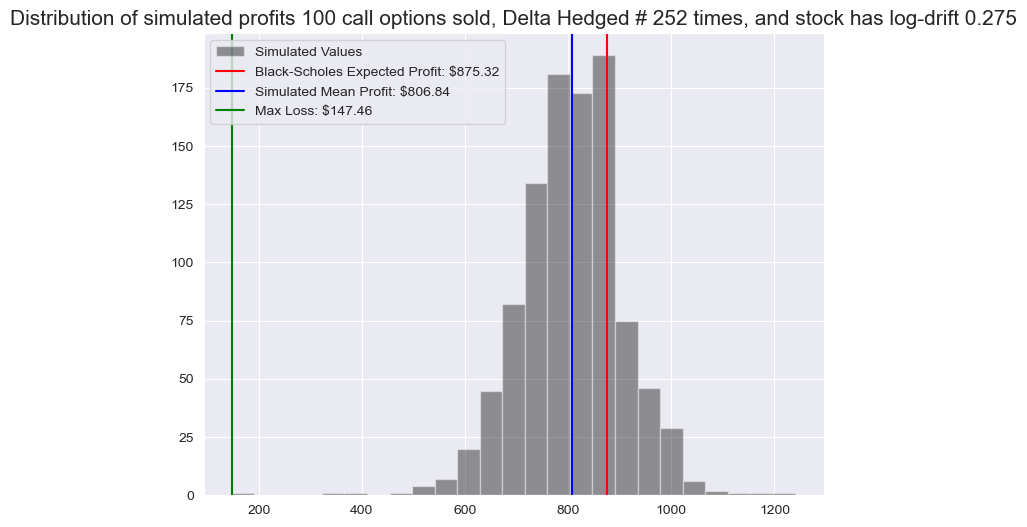

The standard deviation of profits of 252 hedgings using the custom sigma model is 99.25478728030376 
p=2.3411988104779083e-20→ Statistically significant evidence that the data is NOT normally distributed.


In [1162]:
### Here I first use the delta function for this specific model coded above
S0 = 100
K=110
sigma=0.28
t = 1
r = 0.039
mu = 0.275
n_paths = 1000
n_hedges = 252
num_options=100
P= bs_call(S0,K,0.5,t,r)
bs_price = bs_call(S0,K,sigma,t,r)


profits_hedged=custom_sigma_call_PnL(S0, t, r, mu, n_paths,n_hedges, K, P, num_options)

plt.figure(figsize = (8,6))
    
plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
plt.axvline((P-bs_price)*num_options, label = f'Black-Scholes Expected Profit: ${(P-bs_price)*num_options:.2f}', color = 'red')
    
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')
    
plt.legend()

plt.title(f'Distribution of simulated profits {num_options} call options sold, Delta Hedged \
# {n_hedges} times, and stock has log-drift {mu}',size = 15)
    
plt.show()

print(f'The standard deviation of profits of 252 hedgings using the custom sigma model is {np.std(profits_hedged)} ')

p = stats.normaltest(profits_hedged)[1]

if p < 0.05:
    print(f'p={p}→ Statistically significant evidence that the data is NOT normally distributed.')
else:
    print(f'p={p}→ No statistically significant evidence against normality.')

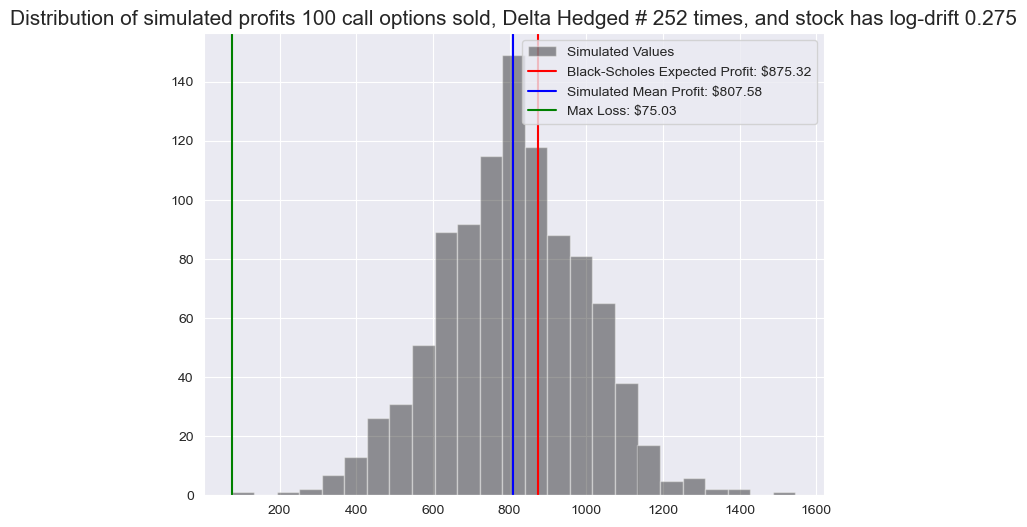

The standard deviation of profits of 252 hedgings using the custom sigma model is 187.22672370780228 
p=0.11180063687429953→ No statistically significant evidence against normality.


In [1480]:
### Let me now use the BS delta

profits_hedged=custom_sigma_call_PnL(S0, t, r, mu, n_paths,n_hedges, K, P, num_options)

plt.figure(figsize = (8,6))
    
plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
plt.axvline((P-bs_price)*num_options, label = f'Black-Scholes Expected Profit: ${(P-bs_price)*num_options:.2f}', color = 'red')
    
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')
    
plt.legend()

plt.title(f'Distribution of simulated profits {num_options} call options sold, Delta Hedged \
# {n_hedges} times, and stock has log-drift {mu}',size = 15)
    
plt.show()

print(f'The standard deviation of profits of 252 hedgings using the custom sigma model is {np.std(profits_hedged)} ')

p = stats.normaltest(profits_hedged)[1]

if p < 0.05:
    print(f'p={p}→ Statistically significant evidence that the data is NOT normally distributed.')
else:
    print(f'p={p}→ No statistically significant evidence against normality.')

Indeed, we can see using the delta defined for this model gives better hedging than using the BS delta, in the sense that the variance or standard deviation in the hedged profits is smaller.

Importantly, I observe that

**Non-constant sigma leads to a smaller meanf profit**

**No matter using which delta (BS or the model-specific one), the variance is bigger than that of the Black-Scholes, i.e., non-constant sigma introduces more invariance in the hedged profits.**

Next, let us look at the Heston model, again let us first code the delta.

In [1229]:
# Delta function of Heston

def heston_call_delta_MC(S0, v0, t, r, mu, kappa, theta, xi, rho, n_steps, n_delta_sims):
    
    """
    Returns the delta of a European call option
    using the Heston model.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        v0 (float): Initial invariance
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate
        mu (float): Drift component (excess return above r)
        alpha (float): Reaction to last step stock price
        beta (float): Persistence of last step variance
        theta (float): Long-run variance
        n_paths (int): Number of Monte Carlo simulation paths
        n_hedges (int): Number of hedge rebalancing intervals
        P (float): Premium received per option sold
        num_options (int): Number of options sold

    Returns:
        float: delta function
    """
    dt = t / n_steps
    N1 = np.random.normal(0, 1, size=(n_delta_sims, n_steps))
    N2 = np.random.normal(0, 1, size=(n_delta_sims, n_steps))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    paths1 = np.zeros((n_delta_sims, n_steps + 1))
    paths2 = np.zeros((n_delta_sims, n_steps + 1))
    vols = np.zeros((n_delta_sims, n_steps + 1))
    paths1[:, 0] = S0+0.01*S0
    paths2[:, 0] = S0-0.01*S0
    vols[:, 0] = v0

    for i in range(n_steps):
        vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
                                xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
        paths1[:, i + 1] = paths1[:, i] * np.exp((r - 0.5 * vols[:, i]) * dt +
                                               np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
        paths2[:, i + 1] = paths2[:, i] * np.exp((r - 0.5 * vols[:, i]) * dt +
                                               np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
    
    C1=np.maximum(paths1[:,-1]-K,0)*np.exp(-r*t)
    C2=np.maximum(paths2[:,-1]-K,0)*np.exp(-r*t)

    return np.mean((C1-C2)/(2*0.01*S0))

# def heston_call_delta_array_MC(S, K, t, r, mu,n_steps, n_delta_sims):
#     """
#     Returns an array of delta functions of a European call option
#     using the Heston model.

#     Parameters:
#         S0 (float): Initial stock price
#         K (float): Strike price
#         v0 (float): Initial invariance
#         t (float): Time to expiration (in years)
#         r (float): Risk-free interest rate
#         mu (float): Drift component (excess return above r)
#         alpha (float): Reaction to last step stock price
#         beta (float): Persistence of last step variance
#         theta (float): Long-run variance
#         n_paths (int): Number of Monte Carlo simulation paths
#         n_hedges (int): Number of hedge rebalancing intervals
#         P (float): Premium received per option sold
#         num_options (int): Number of options sold

#     Returns:
#     np.array: an array of delta functions
#     """
#     dt = t / n_steps
#     N1 = np.random.normal(0, 1, size=(n_delta_sims, n_steps))
#     N2 = np.random.normal(0, 1, size=(n_delta_sims, n_steps))
#     Y = rho * N1 + np.sqrt(1 - rho**2) * N2

#     paths1 = np.zeros((n_delta_sims, n_steps + 1))
#     paths2 = np.zeros((n_delta_sims, n_steps + 1))
#     vols = np.zeros((n_delta_sims, n_steps + 1))
#     paths1[:, 0] = S+0.01*S
#     paths2[:, 0] = S-0.01*S
#     vols[:, 0] = np.array([v0 for i in range(len(S))])

#     for i in range(n_steps):
#         vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
#                                 xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
#         paths1[:, i + 1] = paths1[:, i] * np.exp((r - 0.5 * vols[:, i]) * dt +
#                                                np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
#         paths2[:, i + 1] = paths2[:, i] * np.exp((r - 0.5 * vols[:, i]) * dt +
#                                                np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
    
#     C1=np.maximum(paths1[:,-1]-K,0)*np.exp(-r*t)
#     C2=np.maximum(paths2[:,-1]-K,0)*np.exp(-r*t)

#     return np.mean((C1-C2)/(2*0.01*S),axis=0)

In [1452]:
## test the delta function

S0 = 100
K=110
v0=0.28**2 # expectation value of the volatility given in stock_path_custom_sigma
t = 1
r = 0.039
mu = 0.275
kappa = 4
theta = .45**2
xi = .5
rho = -0.05

n_delta_sims = 100
n_steps = 252

heston_call_delta_MC(S0, v0, t, r, mu, kappa, theta, xi, rho, n_steps, n_delta_sims)

0.43050953718321966

In [1403]:
# Delta hedging with the Heston model

def heston_call_PnL(S0, v0, t, r, mu, kappa, theta, xi, rho, n_paths,n_hedges, K, P, num_options):
    """
    Returns the PnL of a European call option
    under the Henston assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        v0 (float): Initial invariance
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate
        mu (float): Drift component (excess return above r)
        alpha (float): Reaction to last step stock price
        beta (float): Persistence of last step variance
        theta (float): Long-run variance
        n_paths (int): Number of Monte Carlo simulation paths
        n_hedges (int): Number of hedge rebalancing intervals
        P (float): Premium received per option sold
        num_options (int): Number of options sold

    Returns:
        np.array: Profit and loss of the dynamically hedged portfolio under each simulation at regular intervals
    """
   
    dt = t / n_hedges


    # Get the spot prices using the function defined above
    vols,paths=stock_path_Heston(S0, v0, t, r, mu, kappa, theta, xi, rho, n_paths,n_hedges)
    sigma= np.sqrt(vols)

    #Simulate call payouts discounted to time 0
    path_end_points = paths[:,-1]
    call_payouts = np.maximum(path_end_points-K ,0)*np.exp(-r*t)


    #Simulate the stock profits using the BS delta function
    
    stock_profits = []

    for i in range(1,n_hedges+1):
        startpoints=paths[:,i-1]
        endpoints=paths[:,i]
        tte=t-(i-1)*dt
        n_steps=n_hedges-(i-1)
        # deltas=np.array([heston_call_delta_MC(S, v, t, r, mu, kappa, theta, xi, rho, n_steps, n_delta_sims=100) for S,v in zip(startpoints,vols[:,i-1])])
        deltas=bs_call_delta(startpoints,K,sigma[:,i-1],tte,r)
        
        stock_profit=(endpoints-np.exp(r*dt)*startpoints)*deltas*np.exp(-i*r*dt)
        stock_profits.append(stock_profit)

    
    total_stock_profit = np.sum(stock_profits, axis = 0)

   

    # Final P&L
    pnl = num_options * (P - call_payouts + total_stock_profit)

    return pnl

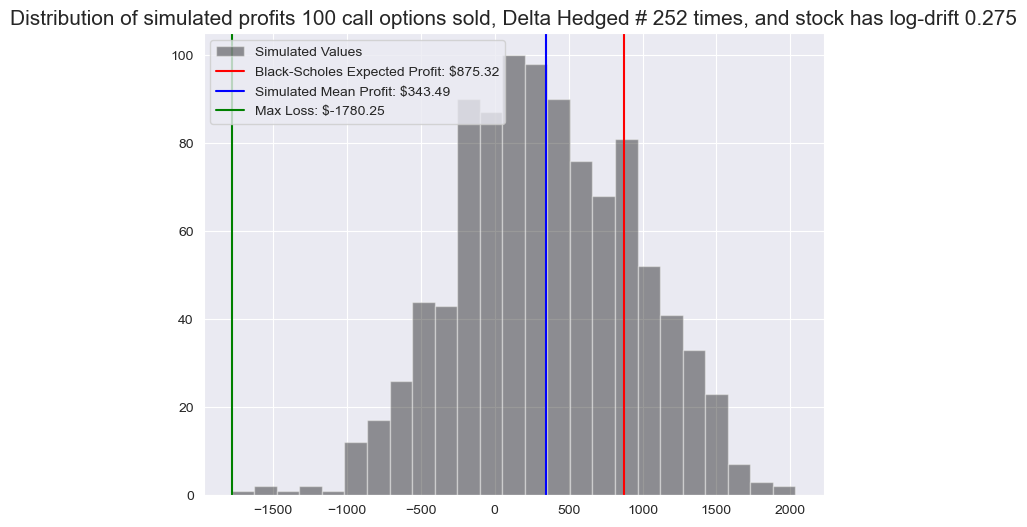

The standard deviation of profits of 252 hedgings using the Heston model is 598.4433701982895 
p=0.2839428789513539→ No statistically significant evidence against normality.


In [1245]:
### First use the delta of Heston model
S0 = 100
K=110
v0=0.28**2 # expectation value of the volatility given in stock_path_custom_sigma
t = 1
r = 0.039
mu = 0.275
kappa = 4
theta = .45**2
xi = .5
rho = -0.05

n_paths = 1000
n_hedges = 252
num_options=100
P= bs_call(S0,K,0.5,t,r)
bs_price = bs_call(S0,K,sigma,t,r)


profits_hedged=heston_call_PnL(S0, v0, t, r, mu, kappa, theta, xi, rho, n_paths,n_hedges, K, P, num_options)

plt.figure(figsize = (8,6))
    
plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
plt.axvline((P-bs_price)*num_options, label = f'Black-Scholes Expected Profit: ${(P-bs_price)*num_options:.2f}', color = 'red')
    
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')
    
plt.legend()

plt.title(f'Distribution of simulated profits {num_options} call options sold, Delta Hedged \
# {n_hedges} times, and stock has log-drift {mu}',size = 15)
    
plt.show()

print(f'The standard deviation of profits of 252 hedgings using the Heston model is {np.std(profits_hedged)} ')

p = stats.normaltest(profits_hedged)[1]

if p < 0.05:
    print(f'p={p}→ Statistically significant evidence that the data is NOT normally distributed.')
else:
    print(f'p={p}→ No statistically significant evidence against normality.')

3.380306604444161
33.43514554547317
19.2727295440195


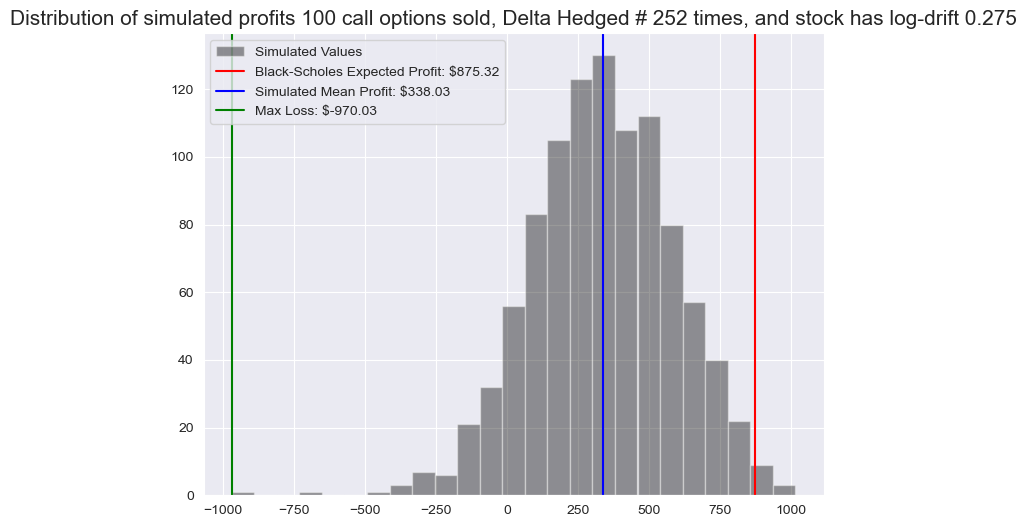

The standard deviation of profits of 252 hedgings using the Heston model is 248.11626464755682 
p=9.903881567376776e-06→ Statistically significant evidence that the data is NOT normally distributed.


In [1432]:
#using the BS delta

S0 = 100
K=110
v0=0.28**2 # expectation value of the volatility given in stock_path_custom_sigma
t = 1
r = 0.039
mu = 0.275
kappa = 4
theta = .45**2
xi = .5
rho = -0.05

n_paths = 1000
n_hedges = 252
num_options=100
P= bs_call(S0,K,0.5,t,r)
bs_price = bs_call(S0,K,sigma,t,r)

profits_hedged=heston_call_PnL(S0, v0, t, r, mu, kappa, theta, xi, rho, n_paths,n_hedges, K, P, num_options)

plt.figure(figsize = (8,6))
    
plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
plt.axvline((P-bs_price)*num_options, label = f'Black-Scholes Expected Profit: ${(P-bs_price)*num_options:.2f}', color = 'red')
    
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')
    
plt.legend()

plt.title(f'Distribution of simulated profits {num_options} call options sold, Delta Hedged \
# {n_hedges} times, and stock has log-drift {mu}',size = 15)
    
plt.show()

print(f'The standard deviation of profits of 252 hedgings using the Heston model is {np.std(profits_hedged)} ')

p = stats.normaltest(profits_hedged)[1]

if p < 0.05:
    print(f'p={p}→ Statistically significant evidence that the data is NOT normally distributed.')
else:
    print(f'p={p}→ No statistically significant evidence against normality.')

Here, the BS delta seems to give a better hedge. I think this is because there are variances in my MC simulations of delta given the number of simulations is 100, which is relatively small.

I believe larger number of simulations for delta will give a better hedging using the Heston delta function. 

Again, the expected profit decreases, and the variance increases in Heston model, comparing to the Black-Scholes model.


In [1407]:
# Delta hedging with the GARCH(1,1) model. 

# Here, I do not bother to write the delta function of the GARCH(1,1) model. The idea is similar with that in Heston model.
# Instead, I directly use the BS delta function.

def garch_call_PnL(S0, v0, t, r, mu, alpha, beta, theta, n_paths,n_hedges, K, P, num_options):
    """
    Returns the PnL of a European call option
    under the Henston assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        v0 (float): Initial invariance
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate
        mu (float): Drift component (excess return above r)
        alpha (float): Reaction to last step stock price
        beta (float): Persistence of last step variance
        theta (float): Long-run variance
        n_paths (int): Number of Monte Carlo simulation paths
        n_hedges (int): Number of hedge rebalancing intervals
        P (float): Premium received per option sold
        num_options (int): Number of options sold

    Returns:
        np.array: Profit and loss of the dynamically hedged portfolio under each simulation at regular intervals
    """
   
    dt = t / n_hedges


    # Get the spot prices using the function defined above
    vols,paths=stock_path_GARCH(S0, v0, t, r, mu, alpha, beta, theta, n_paths,n_hedges)
    sigma= np.sqrt(vols)

    #Simulate call payouts discounted to time 0
    path_end_points = paths[:,-1]
    call_payouts = np.maximum(path_end_points-K ,0)*np.exp(-r*t)


    #Simulate the stock profits using the BS delta function
    
    stock_profits = []

    for i in range(1,n_hedges+1):
        startpoints=paths[:,i-1]
        endpoints=paths[:,i]
        tte=t-(i-1)*dt
        n_steps=n_hedges-(i-1)
        deltas=bs_call_delta(startpoints,K,sigma[:,i-1],tte,r)
        
        stock_profit=(endpoints-np.exp(r*dt)*startpoints)*deltas*np.exp(-i*r*dt)
        stock_profits.append(stock_profit)

    
    total_stock_profit = np.sum(stock_profits, axis = 0)

    # Final P&L
    pnl = num_options * (P - call_payouts + total_stock_profit)

    return pnl

-1.4891891011454026
57.66980045634012
38.63788874929689


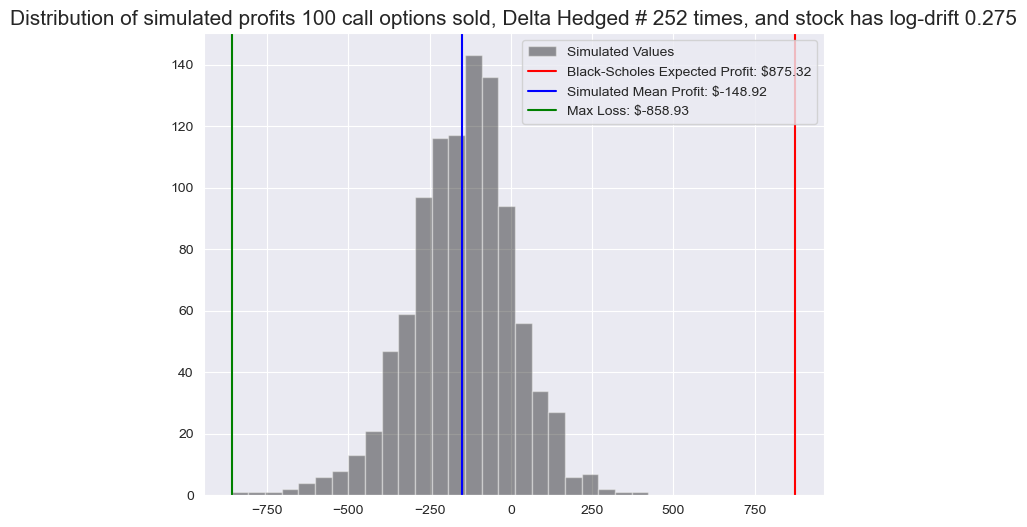

The standard deviation of profits of 252 hedgings using the GARCH(1,1) model is 159.39925353839533 
p=2.705247112191785e-09→ Statistically significant evidence that the data is NOT normally distributed.


In [1429]:
S0 = 100
K=110
v0=0.28**2 # expectation value of the volatility given in stock_path_custom_sigma
t = 1
r = 0.039
mu = 0.275
alpha=0.1
beta=0.2
theta = .45**2

n_paths = 1000
n_hedges = 252
num_options=100
P= bs_call(S0,K,0.5,t,r)
bs_price = bs_call(S0,K,sigma,t,r)


profits_hedged=garch_call_PnL(S0, v0, t, r, mu, alpha, beta, theta, n_paths,n_hedges, K, P, num_options)

plt.figure(figsize = (8,6))
    
plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
plt.axvline((P-bs_price)*num_options, label = f'Black-Scholes Expected Profit: ${(P-bs_price)*num_options:.2f}', color = 'red')
    
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')
    
plt.legend()

plt.title(f'Distribution of simulated profits {num_options} call options sold, Delta Hedged \
# {n_hedges} times, and stock has log-drift {mu}',size = 15)
    
plt.show()

print(f'The standard deviation of profits of 252 hedgings using the GARCH(1,1) model is {np.std(profits_hedged)} ')

p = stats.normaltest(profits_hedged)[1]

if p < 0.05:
    print(f'p={p}→ Statistically significant evidence that the data is NOT normally distributed.')
else:
    print(f'p={p}→ No statistically significant evidence against normality.')

Here the expected profit becomes negative basically due to this model will give a larger $C_0$ and my premium is too small. Nevertheless, the hedging still works because the mean profit here is not sensitive to the drift.

Since in all these three cases with non-constant sigma, the variance of the hedged profits increase comparing to that of the BS model due to the variance of volatility. In the following, I will explore the combination of delta-hedging and vega-hedging to control the sensitivity to both the spot price and the volatility. The idea is to sell call options and meanwhile buy put options, and we need to delta hedging for both sold call options and bought put options. Consider a case where the call options and put options have the same strike price $K$ and time to expiration $t=1$ year. We then buy the same amout of put options as the amount of call options sold. We delta hedge the options each day (252 hedgings) using the Black-Scholes delta function for the time-dependent volatility. Then the hedged profits will have no fluctuations and only depend on the premium of the call and put options. This can be seeing from 

$$\text{Put payouts}-\text{Call payouts}=\text{max}(K-S_t,0)\exp(-rt)-\text{max}(S_t-K,0)\exp(-rt)=(K-S_t) \exp(-rt)$$

and 

$$\text{Stock profits}=\sum_{i}(S_{i}-S_{i-1}\exp(rdt))(\Delta_c-\Delta_p)\exp(-irdt)=S_t\exp(-rt)-S_0$$

where $dt=t/(\text{number of hedges})$ and $\Delta_c-\Delta_p=1$ for call options and put options with the same parameters in the Black-Scholes model. Therefore, the hedged profits can be calculated through

$$\text{hedged profits}=\text{Premium call}-\text{Premium put}+(\text{Put payouts}-\text{Call payouts})+\text{Stock profits}=\text{Premium call}-\text{Premium put}+K\exp(-rt)-S_0$$

which is a fixed number and has no fluctuation. This is always true no matter what model we use to simulate $S_t$, as long as we conduct the delta hedgings using delta functions such that the call-put duality holds. We have already seen from this special case that buying put options can hedge the dependence on volatility. More generally, we want to buy $\frac{\text{call option vega}}{\text{put option vega}}$ put options for each sold call option to make the portfolio vega neutral.


Let me now numerically explore for the effect of buying put options to realize vega hedging for more general cases where the strikes of call options and put options are different. In these cases, the delta function for the call and put options generally does not satisfy the duality, and thus there will be fluctuations. Let me focus on the custom sigma model in the following.

In [1585]:
def custom_sigma_sell_call_buy_put_PnL(S0, t, r, mu, n_paths,n_hedges, Kc, Pc, Kp, Pp, num_options_call):
    """
    Returns the PnL of a European call option
    using the custom volatility for geometric Browian motion.

    Parameters:
        S0 (float): Initial stock price
        Kc (float): Strike price of the call option
        Kp (float): Strike price of the put option
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate
        mu (float): Drift component (excess return above r)
        n_hedges (int): Number of hedges
        n_paths (int): Number of Monte Carlo simulations
        Pc (float): Premium received per call option sold
        Pp (float): Premium spent per put option bought
        num_options_call (int): Number of call options sold

    Returns:
        np.array: PnL
    """
   
    dt = t / n_hedges


    # Get the spot prices using the function defined above
    sigma,paths=stock_path_custom_sigma(S0, t, r, mu, n_paths, n_hedges)

    # Simulate call payouts discounted to time 0
    path_end_points = paths[:,-1]
    call_payouts = np.maximum(path_end_points-Kc ,0)*np.exp(-r*t)


    # Profits from buying put options
    call_put_ratio=(bs_vega(S0, Kc, sigma[:,0], t, r)/bs_vega(S0, Kp, sigma[:,0],t,r))
    put_payouts=np.maximum(Kp-path_end_points ,0)*np.exp(-r*t)* call_put_ratio


    #Simulate the stock profits using the BS delta function
    
    stock_profits = []

    for i in range(1,n_hedges+1):
        startpoints=paths[:,i-1]
        endpoints=paths[:,i]
        tte=t-(i-1)*dt
        n_steps=n_hedges-(i-1)
        #deltas=custom_sigma_call_delta_array_MC(startpoints, K, tte, r, mu,n_steps, n_delta_sims=1000)
        deltasc=bs_call_delta(startpoints,Kc,sigma[:,i-1],tte,r)
        deltasp=bs_put_delta(startpoints,Kp,sigma[:,i-1],tte,r)
        
        stock_profit=(endpoints-np.exp(r*dt)*startpoints)*(deltasc-call_put_ratio*deltasp)*np.exp(-i*r*dt)
        stock_profits.append(stock_profit)

    
    total_stock_profit = np.sum(stock_profits, axis = 0)

    # print(np.mean(call_payouts))
    # print(np.mean(put_payouts))
    # print(np.mean(total_stock_profit))

    # Final P&L
    pnl = num_options_call * (Pc-Pp - call_payouts+ put_payouts + total_stock_profit)

    return pnl

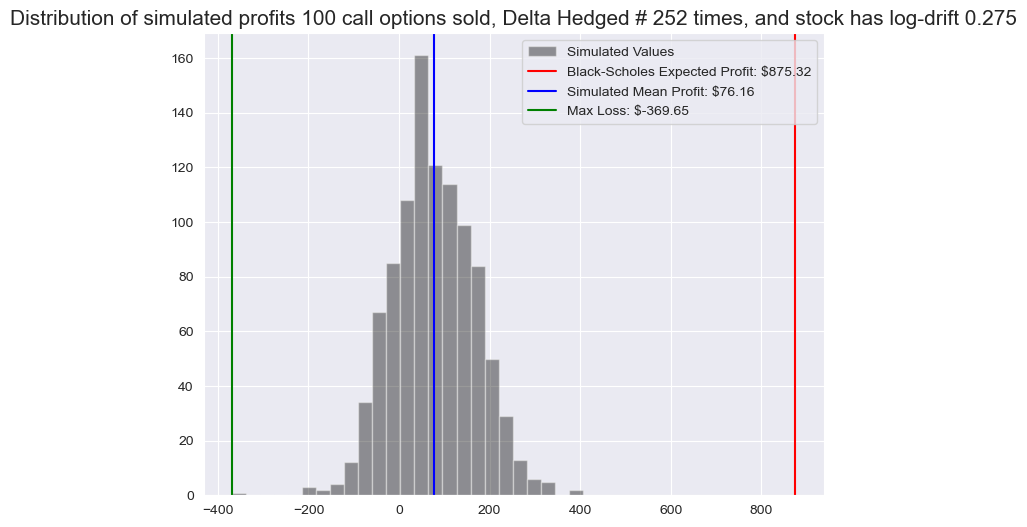

The standard deviation of profits of 252 hedgings using the custom sigma model and meanwhile buying put options is 90.13435214956475 
p=0.009775508811790349→ Statistically significant evidence that the data is NOT normally distributed.


In [1621]:
S0 = 100
Kc=110
Kp=115
v0=0.28**2 # expectation value of the volatility given in stock_path_custom_sigma
t = 1
r = 0.039
mu = 0.275
alpha=0.1
beta=0.2
theta = .45**2

n_paths = 1000
n_hedges = 252
num_options_call=100
Pc= bs_call(S0,Kc,0.5,t,r)
Pp= bs_put(S0,Kp,0.5,t,r)
bs_price = bs_call(S0,Kc,sigma,t,r)


profits_hedged=custom_sigma_sell_call_buy_put_PnL(S0, t, r, mu, n_paths,n_hedges, Kc, Pc, Kp, Pp, num_options_call)

plt.figure(figsize = (8,6))
    
plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
plt.axvline((P-bs_price)*num_options, label = f'Black-Scholes Expected Profit: ${(P-bs_price)*num_options:.2f}', color = 'red')
    
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')
    
plt.legend()

plt.title(f'Distribution of simulated profits {num_options} call options sold, Delta Hedged \
# {n_hedges} times, and stock has log-drift {mu}',size = 15)
    
plt.show()

print(f'The standard deviation of profits of 252 hedgings using the custom sigma model and meanwhile buying put options is {np.std(profits_hedged)} ')

p = stats.normaltest(profits_hedged)[1]

if p < 0.05:
    print(f'p={p}→ Statistically significant evidence that the data is NOT normally distributed.')
else:
    print(f'p={p}→ No statistically significant evidence against normality.')

As long as the difference between call and put option strike price is not too large, buying put options for each sold call options indeed significantly reduce the variance of the hedged profits. When the difference in the strike prices become larger, I observe that the variance will increase. One reason can be seen directly is that the gamma function (second derivation with respect to spot price) will become larger and introduce variance.